# Imports y Setup

In [1]:
!!pip install -qq transformers

['\x1b[?25l',
 '\x1b[K     |▍                               | 10kB 18.1MB/s eta 0:00:01',
 '\x1b[K     |▉                               | 20kB 1.8MB/s eta 0:00:01',
 '\x1b[K     |█▎                              | 30kB 2.3MB/s eta 0:00:01',
 '\x1b[K     |█▊                              | 40kB 2.5MB/s eta 0:00:01',
 '\x1b[K     |██▏                             | 51kB 2.0MB/s eta 0:00:01',
 '\x1b[K     |██▋                             | 61kB 2.3MB/s eta 0:00:01',
 '\x1b[K     |███                             | 71kB 2.6MB/s eta 0:00:01',
 '\x1b[K     |███▍                            | 81kB 2.7MB/s eta 0:00:01',
 '\x1b[K     |███▉                            | 92kB 2.9MB/s eta 0:00:01',
 '\x1b[K     |████▎                           | 102kB 2.8MB/s eta 0:00:01',
 '\x1b[K     |████▊                           | 112kB 2.8MB/s eta 0:00:01',
 '\x1b[K     |█████▏                          | 122kB 2.8MB/s eta 0:00:01',
 '\x1b[K     |█████▌                          | 133kB 2.8MB/s eta 0:00:01',
 '\x1b

In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import tarfile
import os

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from collections import defaultdict
from _collections_abc import dict_keys
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Cargar data

In [4]:
os.environ['KAGGLE_USERNAME'] = 'axelmpm'
os.environ['KAGGLE_KEY'] = 'd5d04d9ea016e97907745797d03ac1f4'
!kaggle competitions download -c nlp-getting-started

401 - Unauthorized


# Procesar data

3271 4342


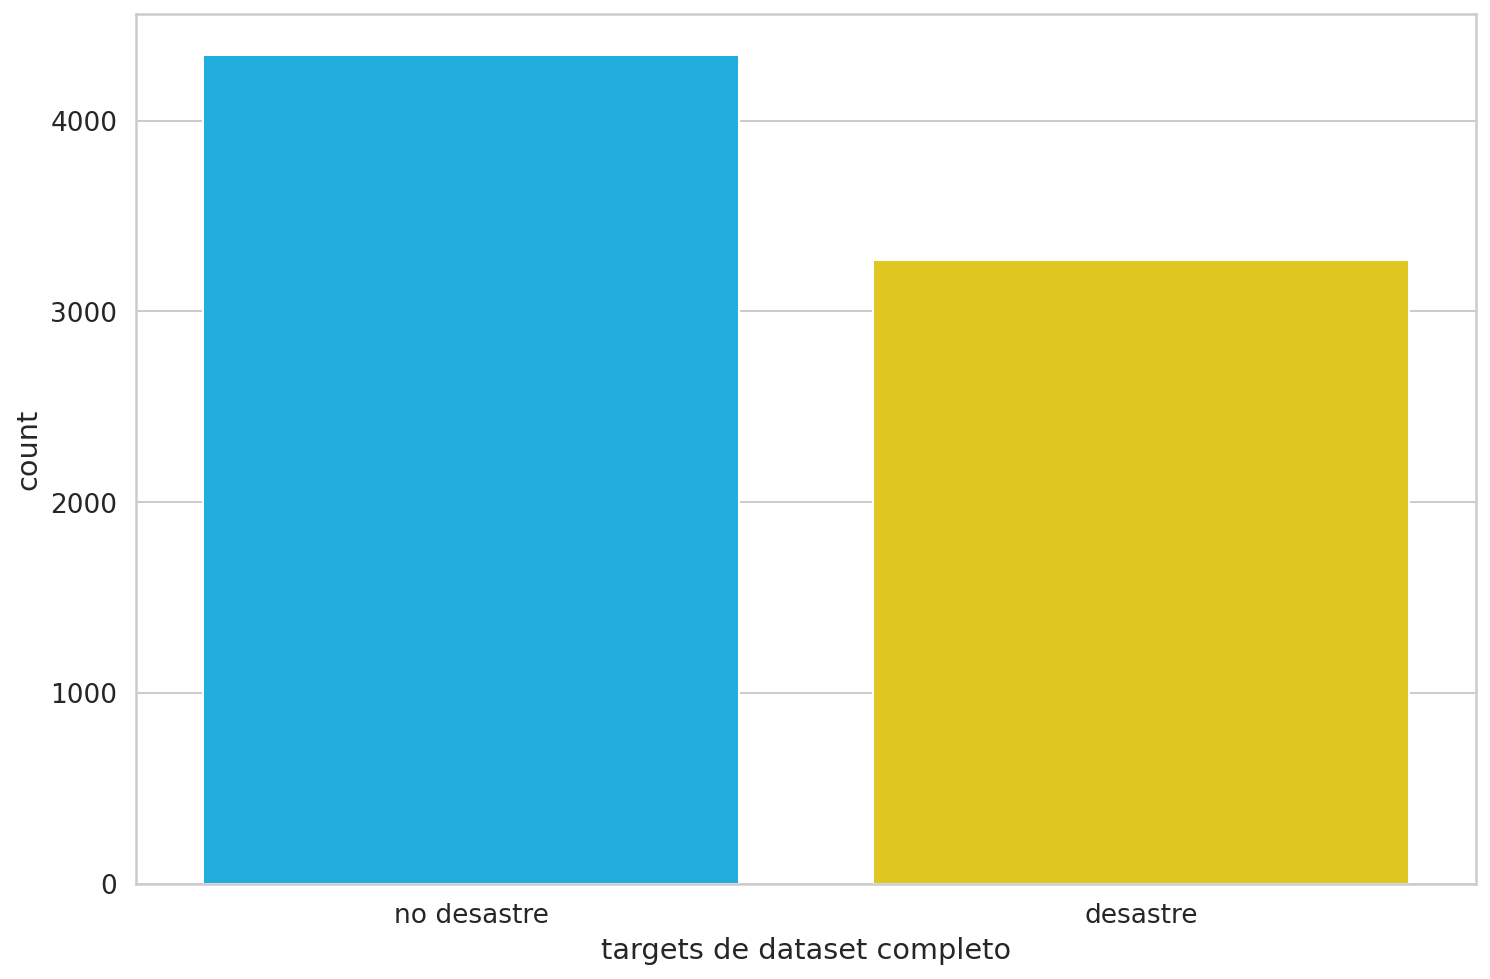

In [ ]:
data = pd.read_csv('train.csv').fillna(' ')
data['complete_text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']

tag_1 = data[data['target'] == 1]
tag_0 = data[data['target'] == 0]


ax = sns.countplot(data.target)
plt.xlabel('targets de dataset completo')
ax.set_xticklabels(['no desastre','desastre']);
print(len(tag_1),len(tag_0))

(5886, 1727)

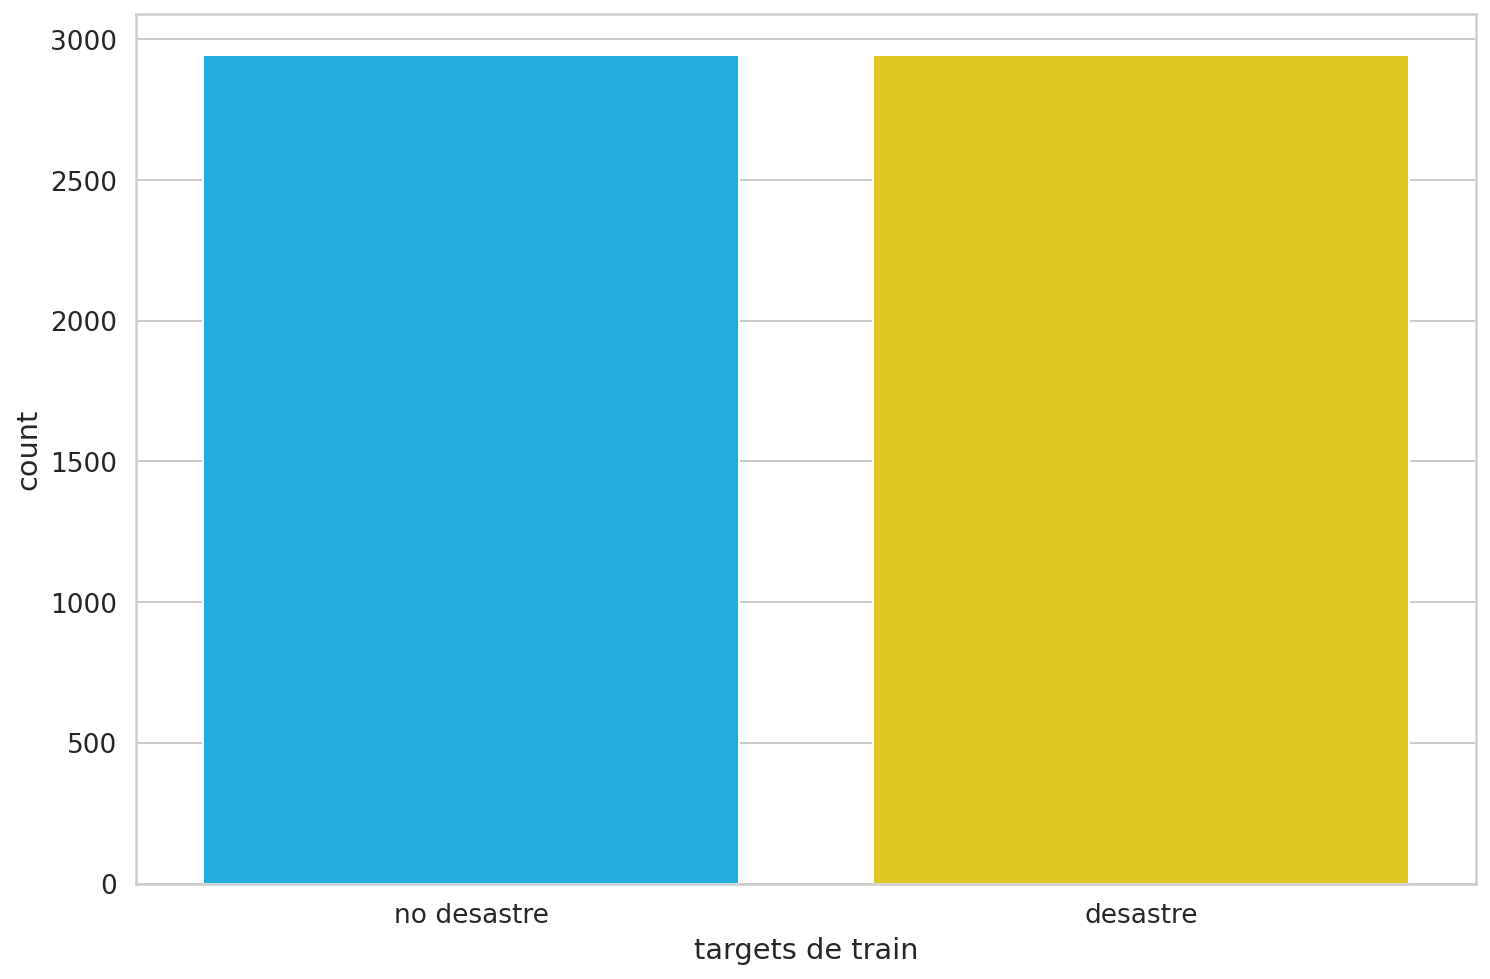

In [ ]:
#Esto es para que el set de train este equilibrado entre 1 y 0 y para que el 
#set de validacion tenga solo datos nuevos que no se usaron en train 
#y que a la vez no se termine dejando ningun dato sin usar

tag_1_val_size = 0.1

tag_0_val_size = 1 - (len(tag_1) * (1 - tag_1_val_size))/(len(tag_0))

tag_1_train, tag_1_val = train_test_split(tag_1, test_size = tag_1_val_size)
tag_0_train, tag_0_val = train_test_split(tag_0, test_size = tag_0_val_size)

train = pd.concat([tag_1_train,tag_0_train])
val = pd.concat([tag_1_val,tag_0_val])

ax = sns.countplot(train.target)
plt.xlabel('targets de train')
ax.set_xticklabels(['no desastre','desastre']);
len(train),len(val)

porcentaje de tweets que quedan cortados: 3.64%


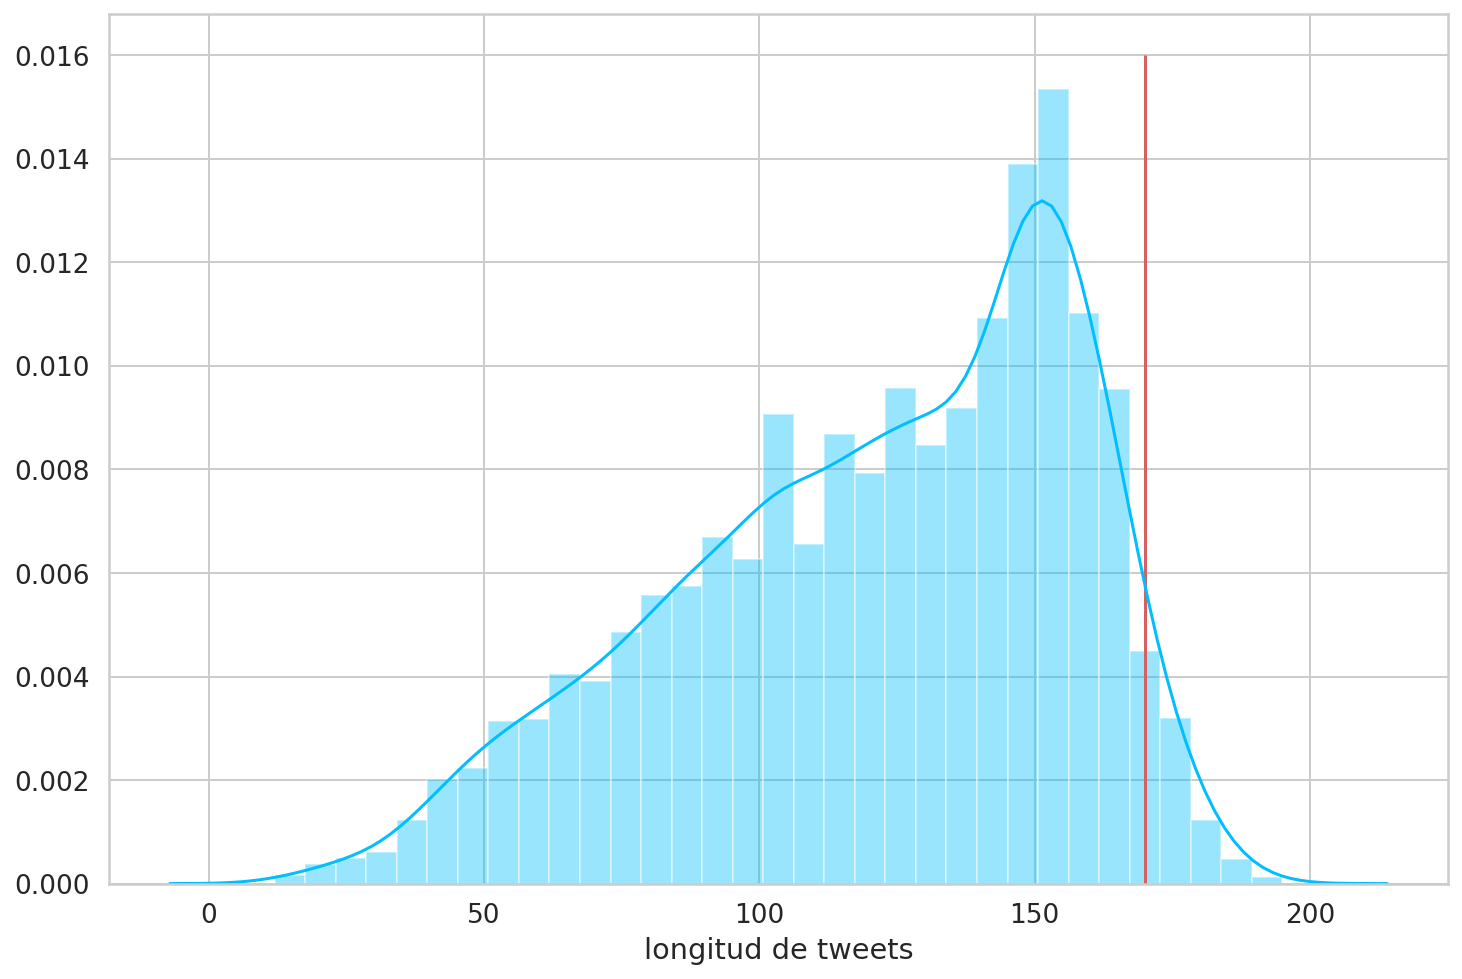

In [ ]:
# BERT requiere una longitud maxima y mas rapido entrena cuando mas corta es la longitud por lo que estoy buscando con que longitud maxima quedarme sin tirar demasiados tweets

MAX_LEN = 170

lens = data.complete_text.apply(len)

sns.distplot(lens)
plt.xlabel('longitud de tweets');
plt.vlines(x=MAX_LEN, ymin=0, ymax=0.016,  color = 'r')

print("porcentaje de tweets que quedan cortados: {}%".format(round(len(lens[ lens > MAX_LEN ])/len(data) * 100,2)))

# Preparar el modelo

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class TweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = TweetDataset(
    tweets=df.complete_text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16

train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE) TODO

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes,dropout):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
DROPOUT = 0.3

model = SentimentClassifier(2,DROPOUT)
model = model.to(device)

# Entrenar

In [ ]:
EPOCHS = 10
LEARNING_RATE = 5e-6
WARM_UP_STEPS = 1

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=WARM_UP_STEPS,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:

    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.15788899799403938 accuracy 0.9707781175671085
Val   loss 1.390277136291843 accuracy 0.8100752750434278

Epoch 2/10
----------


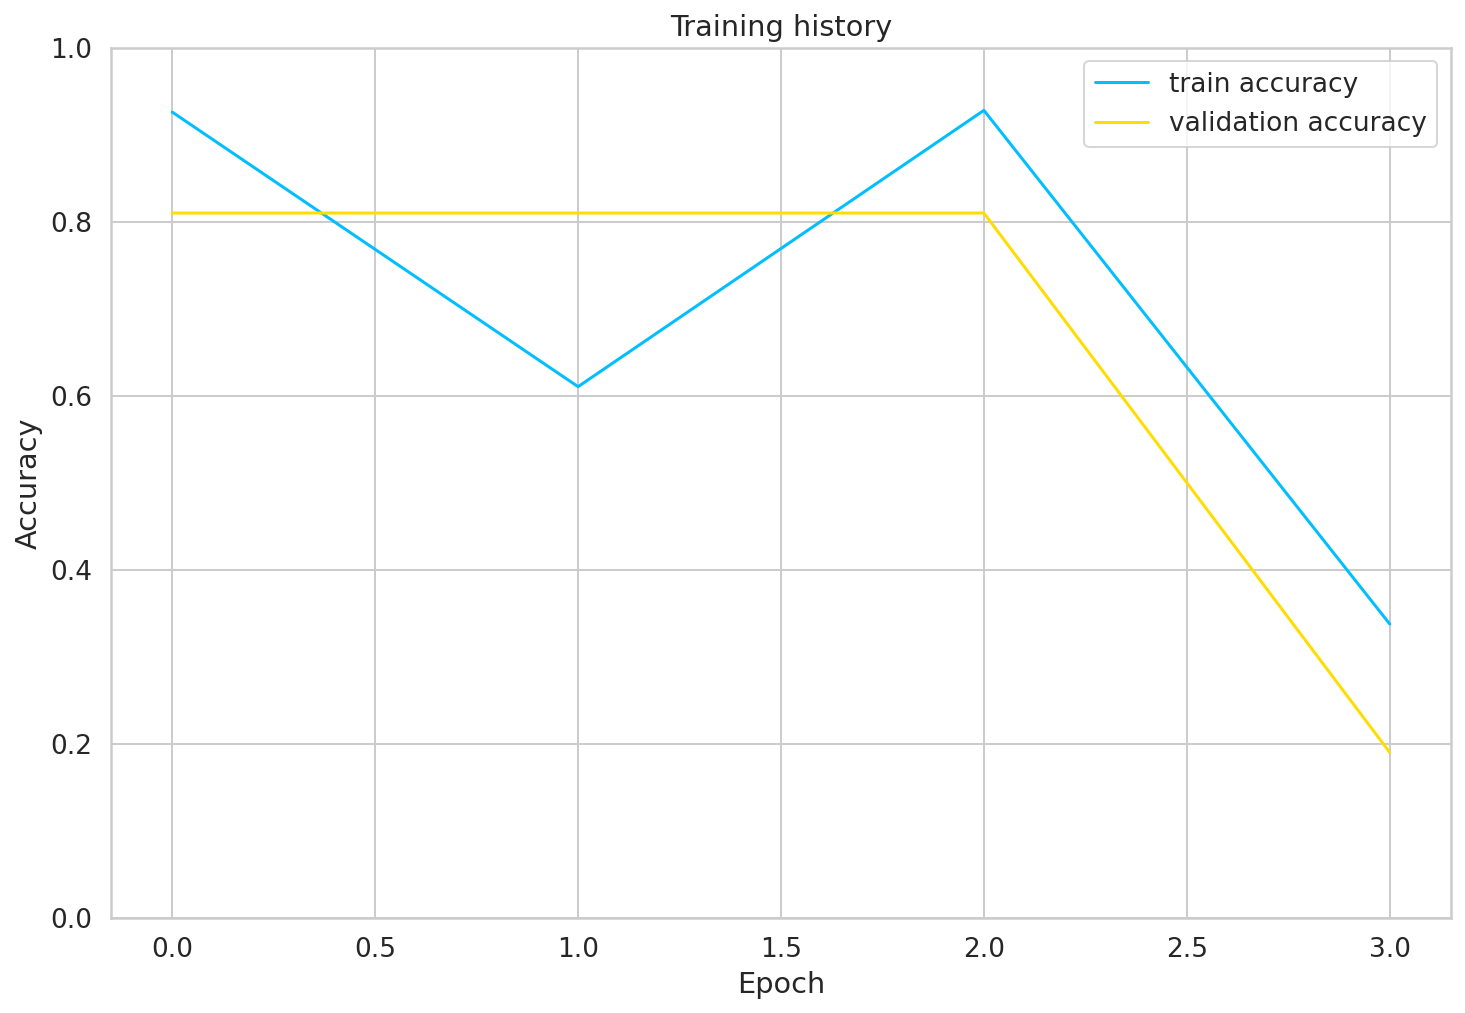

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.ylim([0, 1]);

# Predecir

In [ ]:
to_predict = pd.read_csv('test.csv').fillna(' ')
to_predict['complete_text'] = to_predict['keyword'] + ' ' + to_predict['location'] + ' ' + to_predict['text']
len(to_predict)

3263

In [ ]:
preds = []
for tweet in to_predict.complete_text:
    encoded = tokenizer.encode_plus(
        tweet,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True,
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    preds.append(int(max(output[0])))

In [ ]:

n = 444
encoded = tokenizer.encode_plus(
    to_predict.complete_text[n],
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True,
)
to_predict.complete_text[n]

'body%20bagging Bloemfontein, Free State @MeekMill I think its time you consulted @kendricklamar cause @Drake done body bagging you'

In [ ]:
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)
s = model(input_ids, attention_mask)

In [ ]:
s

tensor([[-0.7511,  0.2664]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
int(max(s[0]))

0

In [ ]:
input_ids

tensor([[  101,  1404,   110,  1406, 17097,  3375,   139,  2858,  5521, 14467,
         11656,  1394,   117,  4299,  1426,   137,  2508,  4820,  2107,  7956,
           146,  1341,  1157,  1159,  1128, 18881,   137,   180,  6696,  8053,
          7609,  1813,  2612,   137,  7431,  1694,  1404,  3821,  3375,  1128,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
to_predict['target'] = pd.Series(preds)
submit = to_predict[['id','target']].set_index('id')
submit

,target
id,
0,0
2,0
3,0
9,0
11,0
...,...
10861,0
10865,0
10868,0


In [ ]:
submit[ submit.target == 0]

,target
id,
0,0
2,0
3,0
9,0
11,0
...,...
10861,0
10865,0
10868,0


# Genero Submit

In [ ]:
VERSION = 1 \
submit_name = 'BERT_submit_' + str(VERSION)

SyntaxError: ignored

SyntaxError: ignored

SyntaxError: ignored

In [ ]:
submit.to_csv(submit_name + '.csv')

In [ ]:
submit.to_csv('submission.csv')
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m submit_name

# Referencia

https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/